# Project 2

## Introduction

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
import plotly.express as px

%matplotlib inline
np.random.seed(0)
random_state = 42

In [109]:
test_sizes = [0.2, 0.4, 0.7]
noises = [0.1, 0.2, 0.3]

n_estimators = np.arange(1, 501, 50)
max_depth = [None, 5, 10]
min_samples_split = [2, 5, 10]
learning_rate = [0.01, 0.1, 1]

stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
variance_threshold = VarianceThreshold()

rf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
gb = GradientBoostingClassifier(random_state=random_state)
dummy = DummyClassifier(strategy='most_frequent')

### Read dataset. Define noise and mislabeling.

In [110]:
# read data
X_cancer = pd.read_csv('../data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
Y_cancer = pd.read_csv('../data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)

# merge to have the dataset in one dataframe
data_cancer = pd.concat([X_cancer, Y_cancer], axis=1)

Y_cancer['x'].unique()
# assign a numbered label for Y
label_map_cancer = {'GBM': 0, 'BC': 1, 'OV': 2, 'LU': 3, 'KI': 4, 'U': 5}
Y_cancer['x'] = Y_cancer['x'].map(label_map_cancer)

/tmp/ipykernel_347033/831625756.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_cancer = pd.read_csv('../data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
/tmp/ipykernel_347033/831625756.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Y_cancer = pd.read_csv('../data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)


In [111]:
X_cats_dogs = pd.read_csv('../data/CATSnDOGS.csv')

# TODO: add the label to the dataset

In [112]:
def splits(X, Y, gaussian_noise_factor=0, test_size=0.2):
    ''' Split into train and test. Includes noise and mislabeling. '''
    noise = np.random.normal(0, 1, X.shape)
    X = X + gaussian_noise_factor * noise
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)
    
    return X_train, X_test, Y_train, Y_test

### Exploratory Data Analysis

In [113]:
X_cats_dogs.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4087,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095,V4096
0,23,116,227,149,49,131,31,31,86,86,...,59,116,102,78,102,102,116,139,152,166
1,247,247,245,245,245,245,245,235,235,223,...,110,100,100,70,66,70,70,70,70,78
2,77,77,77,87,87,94,94,94,105,87,...,116,125,128,128,128,128,125,125,116,116
3,32,28,28,28,28,28,28,28,28,28,...,73,73,73,79,108,131,148,148,148,131
4,3,44,112,136,120,120,125,122,129,133,...,186,184,181,180,179,173,170,192,119,14


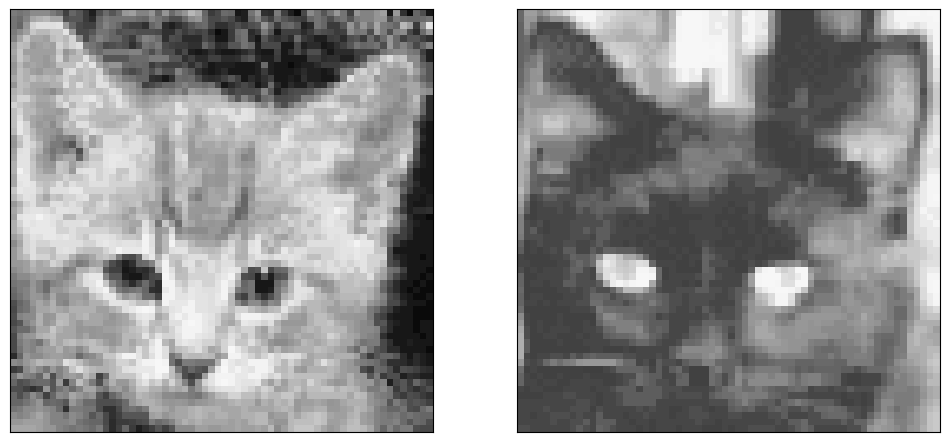

In [114]:
def rotateM(x):
    return np.transpose(np.apply_along_axis(np.flip, 0, x))

# ssc = np.random.choice(np.where(Labels == 0)[0], 2, replace=False)
# ssd = np.random.choice(np.where(Labels == 1)[0], 2, replace=False)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, ax in enumerate(axs):
    # convert series in numpy array and reshape to 64x64
    image = X_cats_dogs.iloc[i].values.reshape(64, 64)
    ax.imshow(rotateM(image), cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Setup

### Question 1

In [115]:
# Parameter grid for Random Forest (bagging)
params_rf_1 = {
    'classifier__n_estimators': n_estimators,
    # 'classifier__max_depth': max_depth,
    # 'classifier__min_samples_split': min_samples_split,
    # 'classifier__max_features': ['sqrt', 'log2'],
}

# Parameter grid for Gradient Boosting
params_gb_1 = {
    'classifier__n_estimators': n_estimators,
    'classifier__max_depth': max_depth,
    'classifier__min_samples_split': min_samples_split,
    'classifier__learning_rate': learning_rate, # for boosting
    
    # TODO: see if the paramters below are useful
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [0, 0.1, 0.5]
}

pipeline_1 = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('classifier', dummy)
])


def grid_search_1(X_train, Y_train, model: str):
    if model == 'rf':
        pipeline_1.steps[1] = ('classifier', rf)
        params = params_rf_1
    elif model == 'gb':
        pipeline_1.steps[1] = ('classifier', gb)
        params = params_gb_1
    else:
        params = {}
    
    grid_search = GridSearchCV(pipeline_1, params, cv=stratified_k_fold, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train, np.ravel(Y_train))
    print('grid_search.best_params_: ', grid_search.best_params_)
    print('grid_search.best_score_: ', grid_search.best_score_)    
    
    return grid_search

def classification_report_1(X_test, Y_test, grid_search_1):
    Y_test_pred_1 = grid_search_1.predict(X_test)
    best_params_1 = grid_search_1.best_params_
    print("Classification Report \nOptimal parameters - ",
        f'{best_params_1['classifier__n_estimators']} estimators, ', 
        f'{best_params_1['classifier__max_depth']} max depth, ', 
        f'{best_params_1['classifier__min_samples_split']} min samples split \n\n',
        classification_report(Y_test, Y_test_pred_1))

In [116]:

def plot_learning_trend(grid_search_res):
  results = grid_search_res.cv_results_
  n_estimators = np.arange(10, 101, 10)
    
  # get the mean test scores for each estmator with the same value of n_estimators
  mean_scores = []
  for n in n_estimators:
    mean_scores.append(np.mean(results['mean_test_score'][results['param_classifier__n_estimators'] == n]))
  
  n_estimators = [int(n) for n in n_estimators]
  print(n_estimators)

  plt.plot(n_estimators, mean_scores, marker='o')
  plt.xlabel('n_estimators')
  plt.ylabel('Mean Test Score')
  plt.title('Trend of Learning for Different n_estimators')
  plt.grid(True)
  plt.show()


In [117]:
def main_seq():
  print('Random Forest\n')
  for noise in noises:
    print(f'Noise: {noise}\n\n')
    X_train, X_test, Y_train, Y_test = splits(X_cancer, Y_cancer, noise)
    grid_search_res = grid_search_1(X_train, Y_train, 'rf')
    plot_learning_trend(grid_search_res)

In [118]:
import concurrent.futures

def main():
  with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for noise in noises:
      futures.append(executor.submit(process_noise, noise))
    
    # for future in concurrent.futures.as_completed(futures):
    #   result = future.result()
      
def process_noise(noise):
  result = f'\n\nNoise: {noise}\n'
  X_train, X_test, Y_train, Y_test = splits(X_cancer, Y_cancer, noise)
  
  result += 'Random Forest\n'
  grid_search_res = grid_search_1(X_train, Y_train, 'rf')
  plot_learning_trend(grid_search_res)
  
  # Uncomment the following lines if you want to include Gradient Boosting
  # result += 'Gradient Boosting\n'
  # grid_search_res = grid_search_1(X_train, Y_train, 'gb')
  # result += plot_learning_trend(grid_search_res)
  
  return result

## Test

Random Forest



Noise: 0.1

grid_search.best_params_:  {'classifier__n_estimators': 51}
grid_search.best_score_:  0.9522761420228922
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


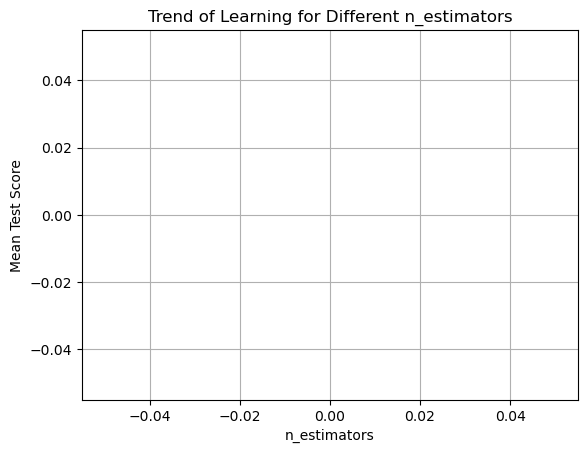



Noise: 0.2

grid_search.best_params_:  {'classifier__n_estimators': 151}
grid_search.best_score_:  0.9510413548879629
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


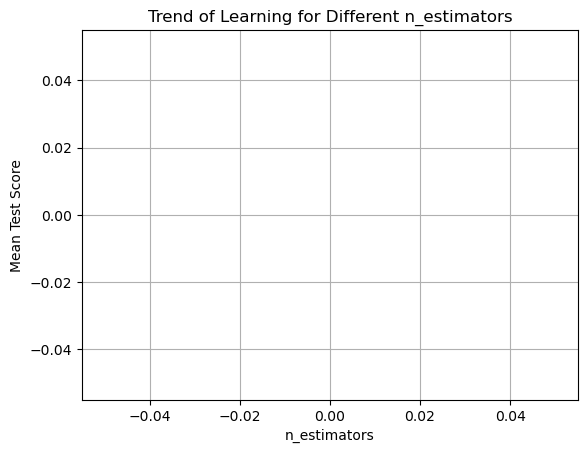



Noise: 0.3

grid_search.best_params_:  {'classifier__n_estimators': 351}
grid_search.best_score_:  0.9481143436276185
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


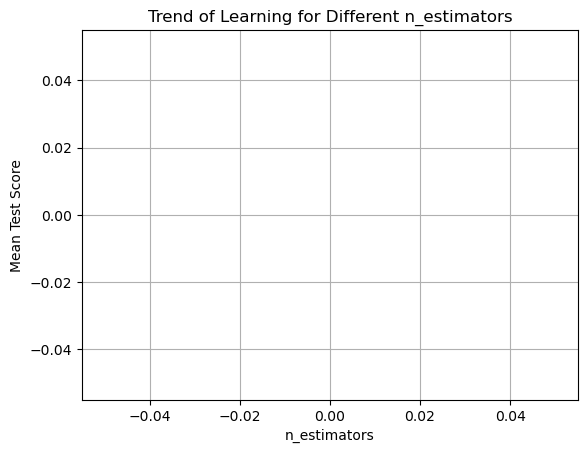

In [119]:
main_seq()

In [120]:
X_train, X_test, Y_train, Y_test = splits(X=X_cancer, Y=Y_cancer, gaussian_noise_factor=0.1, test_size=0.2)
grid_search_1_res = grid_search_1(X_train, Y_train, 'rf')
classification_report_1(X_test, Y_test, grid_search_1_res)

grid_search.best_params_:  {'classifier__n_estimators': 251}
grid_search.best_score_:  0.956274287078859


KeyError: 'classifier__max_depth'

In [ ]:
classification_report_1(X_test, Y_test, grid_search_1_res)

Classification Report 
Optimal parameters -  100 estimators,  5 max depth,  2 min samples split 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.98      1.00      0.99       243
           2       1.00      1.00      1.00        53
           3       1.00      0.99      1.00       114
           4       1.00      0.98      0.99       121
           5       1.00      0.92      0.96        12

    accuracy                           0.99       578
   macro avg       1.00      0.98      0.99       578
weighted avg       0.99      0.99      0.99       578



[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


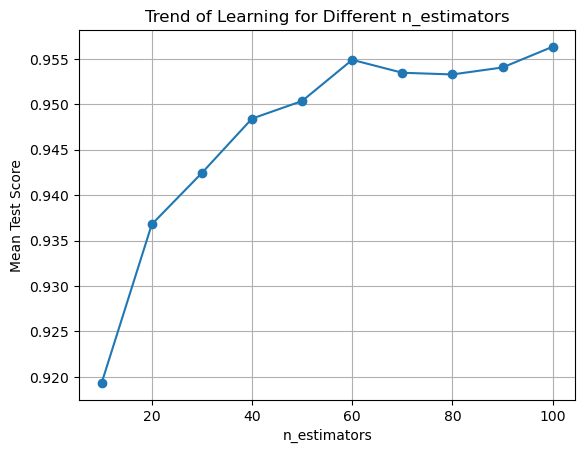

In [ ]:
plot_learning_trend(grid_search_1_res)